In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, brier_score_loss
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# Load the breast cancer dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target column to the DataFrame
df['target'] = data.target

# Split the data into X (features) and y (target)
X = df.drop('target', axis=1)  # Features
y = df['target']  # Target variable
        
threshold = np.mean(y)
y_binary = (y > threshold).astype(int)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
def uncertainty():
        # Define the base model without feature names
        base_model = LogisticRegression(random_state=1, max_iter=5000)

        # Define the BaggingClassifier with 100 base models
        model = BaggingClassifier(estimator=base_model, n_estimators=100, n_jobs=-1, random_state=42)
        model.fit(X_train, y_train)  # Fit the BaggingClassifier without feature names

        y_pred = model.predict(X_test)
        recall = recall_score(y_test, y_pred)
        print(f"Recall of the Bagging Classifier Logistic Regression on the Test Set: {recall:.2f}")

        test_indices = X_test.index
        
        # Get the predictions from each base model in the ensemble
        predictions = np.array([estimator.predict_proba(X_test)[:, 1] for estimator in model.estimators_])

        # Calculate the 5th and 95th percentiles of the predictions
        lower_bound = np.percentile(predictions, 5, axis=0)
        upper_bound = np.percentile(predictions, 95, axis=0)
        median_predictions = np.median(predictions, axis=0)
        
        # Plot error bars for predictions
        indices = range(median_predictions.shape[0])
        plt.figure(figsize=[18,6])
        plt.errorbar(indices, median_predictions, yerr=[median_predictions - lower_bound, upper_bound - median_predictions], fmt='o', capsize=5)
        plt.scatter(indices, y_test.loc[test_indices], marker='s', c='k')
        plt.title('Prediction Uncertainty for the First 100 Samples')
        plt.xlabel('Sample Index')
        plt.ylabel('Predicted Probability')
        plt.ylim(-0.1, 1.1)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        
        threshold = 0.2
        idx = upper_bound - lower_bound < threshold

        accuracy = recall_score(y_test.loc[test_indices][idx], y_pred[idx])
        decisiveness = sum(idx)/idx.shape[0]

        print(f"The Bagging Classifier Logistic Regression can give us certain decisions about {decisiveness:.2f} of the test samples with the recall of: {recall:.2f}")

## Model Robustness at The Prediction Stage: Estimating Epistemic Uncertainty using Bootstrapping Technique

Estimating epistemic uncertainty plays a crucial role in enhancing the safety of AI-based decision-making in several ways.
   
Here, we try to showcase how to use a bag of Logistic Regression to estimate the prediction uncertainty on our adapted cancer dataset. 

Recall of the Bagging Classifier Logistic Regression on the Test Set: 0.96


C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without featu

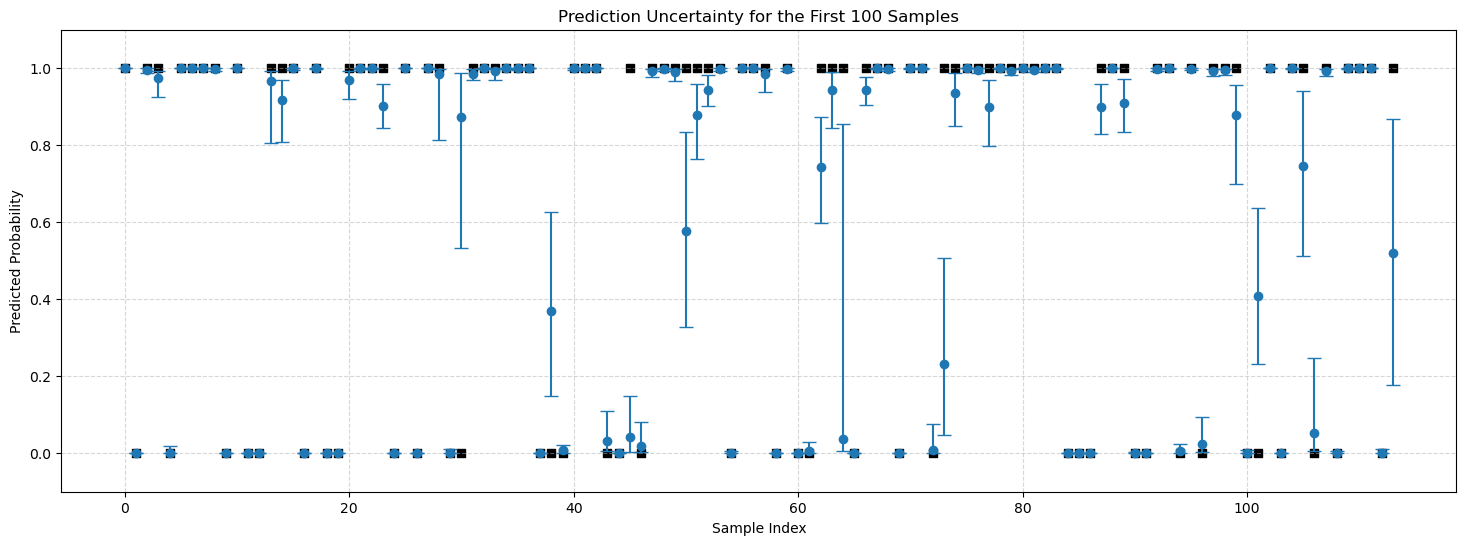

The Bagging Classifier Logistic Regression can give us certain decisions about 0.90 of the test samples with the recall of: 0.96


In [4]:
uncertainty()